In [686]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import yaml

import mscproject.models as mod
import mscproject.experiment as exp

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

In [687]:
# Matplotlib Settings
plt.style.use("seaborn-whitegrid")
plt.style.use("seaborn-paper")

FONT_SIZE = 12

# Set plot font size
plt.rcParams.update({"font.size": 8})

# Set axis label font size
plt.rcParams.update({"axes.labelsize": 10})

# Set legend font size
plt.rcParams.update({"legend.fontsize": 10})

# Set tick label font size
plt.rcParams.update({"xtick.labelsize": 9})

# Set tick label font size
plt.rcParams.update({"ytick.labelsize": 9})

# Set figure title font size
plt.rcParams.update({"axes.titlesize": FONT_SIZE})

In [688]:
conf_dict = yaml.safe_load(Path("config/conf.yaml").read_text())

In [689]:
edges_pre_df = pd.read_parquet(conf_dict["edges"])

In [690]:
edges_post_df = pd.read_parquet(conf_dict["edges_anomalies"])

## Graph Statistics

In [714]:
edges_post_df.is_anomalous.value_counts(normalize=True)

False    0.909235
True     0.090765
Name: is_anomalous, dtype: float64

<AxesSubplot:ylabel='Frequency'>

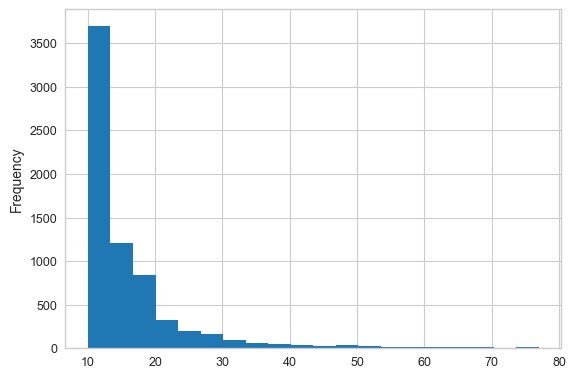

In [691]:
# Get component sizes
component_sizes_pre = edges_pre_df.groupby("component").agg({"src": "count"})
# Select 99% of components
component_sizes_pre = component_sizes_pre.sort_values("src", ascending=True).query(
    "src > 9"
)
component_sizes_pre = component_sizes_pre.iloc[: int(len(component_sizes_pre) * 0.99)]
component_sizes_pre["src"].plot.hist(bins=20, label="Normal")

In [692]:
graph_post = nx.from_pandas_edgelist(edges_post_df, "src", "dst")

In [693]:
# # Get connected components
# components_post = list(nx.connected_components(graph_post))
# # Assign components to edges
# edges_post_df["component"] = edges_post_df["src"].apply(
#     lambda x: [i for i, c in enumerate(components_post) if x in c][0]
# )

<AxesSubplot:ylabel='Frequency'>

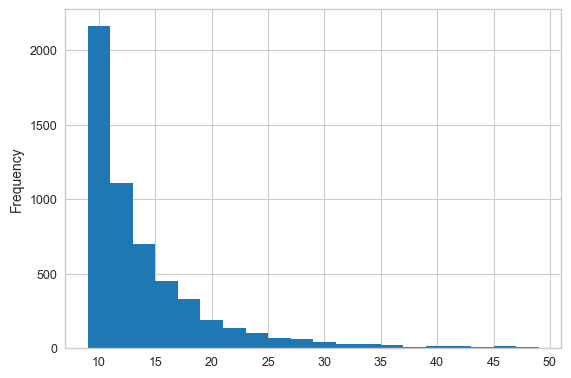

In [694]:
# Get component sizes
component_sizes_post = edges_post_df.groupby("component").agg(
    {"is_anomalous": "sum", "src": "count"}
)
# Select 99% of components
component_sizes_post = component_sizes_post.sort_values("src", ascending=True)
component_sizes_post = component_sizes_post.iloc[
    : int(len(component_sizes_post) * 0.99)
]
component_sizes_post["src"].plot.hist(bins=20, label="Normal")

<AxesSubplot:ylabel='Frequency'>

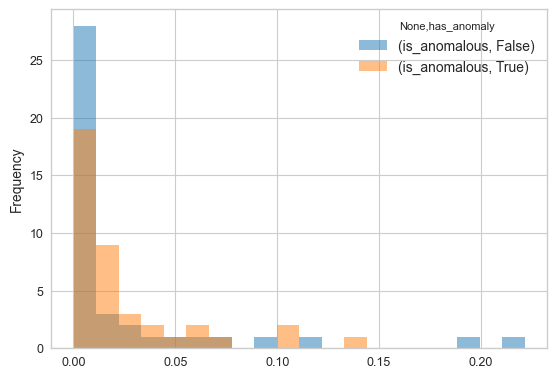

In [730]:
# Get component sizes
component_sizes_post = edges_post_df.groupby(["component"]).agg(
    {"is_anomalous": "sum", "src": "count"}
)
component_sizes_post["has_anomaly"] = component_sizes_post["is_anomalous"] > 0
# Select 99% of components
component_sizes_post = component_sizes_post.sort_values("src", ascending=True)
component_sizes_post = component_sizes_post.iloc[
    : int(len(component_sizes_post) * 0.99)
]
anomaly_dist = component_sizes_post.groupby(["src", "has_anomaly"]).count().unstack()
# normalise
anomaly_dist = anomaly_dist / anomaly_dist.sum()
anomaly_dist.plot.hist(bins=20, alpha=0.5, label="Normal")

In [719]:
component_sizes_post

,is_anomalous,src,has_anomaly
component,,,
6863,0,9,False
1183,0,9,False
1182,0,9,False
1181,0,9,False
3971,0,9,False
...,...,...,...
5933,0,48,False
2593,0,48,False
1036,6,48,True


In [695]:
component_sizes_pre.groupby("src").size().sort_index()[:20]

src
10    1417
11     952
12     764
13     570
14     493
15     396
16     324
17     268
18     245
19     171
20     155
21     139
22      97
23      84
24      79
25      64
26      52
27      53
28      47
29      36
dtype: int64

In [696]:
component_sizes_post.groupby("src").size().sort_index()[:20]

src
9     1140
10    1025
11     613
12     496
13     387
14     310
15     248
16     204
17     169
18     161
19      92
20     100
21      79
22      54
23      57
24      42
25      36
26      30
27      32
28      31
dtype: int64

In [697]:
component_sizes_post.groupby("src").agg(["sum", "count"])

is_anomalous      
             sum count
src                   
9             89  1140
10           131  1025
11           109   613
12            78   496
13            67   387
14            76   310
15            50   248
16            76   204
17            33   169
18            49   161
19            40    92
20            32   100
21            30    79
22            31    54
23            30    57
24            46    42
25            16    36
26            28    30
27            34    32
28            13    31
29            21    19
30            34    20
31            14    20
32            11    11
33            10    10
34            49    19
35            18    13
36            17    11
37             9     6
38             7     5
39             6     3
40            27    10
41             7    10
42            23     5
43            29     8
44             8     3
45            17     8
46             1     6
47             4     2
48            10     4
49             0     1

## Anomaly Simulation

In [698]:
graph_edges_post = edges_post_df.query("component == 23")
graph_edges_post

,component,src,dst,interestedPartyIsPerson,minimumShare,is_anomalous
325,23,2258222399048453312,11395388473527546194,False,75.0,True
3488,23,7777674229742200955,2993799137589768883,False,75.0,False
3489,23,7777674229742200955,3121981569988026883,False,75.0,False
3490,23,7777674229742200955,3436044742148301739,False,75.0,False
3492,23,15507582945687881946,15327826988772839815,False,75.0,False
3494,23,7777674229742200955,16269176336766539906,False,75.0,False
3495,23,7777674229742200955,15507582945687881946,False,75.0,False
3496,23,7777674229742200955,9750640700739922330,False,75.0,False
3498,23,7777674229742200955,16288797838414460695,False,75.0,False
3499,23,7777674229742200955,16807511370466429520,False,75.0,False


In [699]:
edges_pre_df.query("src == '2258222399048453312'")

,component,src,dst,interestedPartyIsPerson,minimumShare
3551,77309426934,2258222399048453312,17957350210417364187,False,25.0


In [700]:
graph_edges_pre = edges_pre_df.query("component == 77309426934").sort_values("src")

In [701]:
edges_in_pre_not_in_post = graph_edges_pre.query(
    "src not in @graph_edges_post.src.values"
)
edges_in_pre_not_in_post

,component,src,dst,interestedPartyIsPerson,minimumShare
3558,77309426934,12193340053346509882,5906392310761780345,True,25.0
3547,77309426934,14144852946696025909,17957350210417364187,True,50.0
3555,77309426934,14144852946696025909,5906392310761780345,True,25.0
3545,77309426934,4875486011478224347,5906392310761780345,True,25.0


In [702]:
graph_pre = nx.DiGraph()
graph_pre.add_nodes_from(graph_edges_pre["src"].unique())
graph_pre.add_nodes_from(graph_edges_pre["dst"].unique())
graph_pre.add_edges_from(graph_edges_pre[["src", "dst"]].values)

In [703]:
graph_post = nx.DiGraph()
graph_post.add_nodes_from(graph_edges_post["src"].unique())
graph_post.add_nodes_from(graph_edges_post["dst"].unique())
graph_post.add_edges_from(graph_edges_post[["src", "dst"]].values)

In [704]:
node_c = "lightblue"
new_node_c = "lightgreen"
dropped_node_c = "lightpink"
anomalous_node_c = "darkorange"

edge_c = "lightgrey"
new_edge_c = "green"
dropped_edge_c = "red"

# new_edge_c = edge_c
# dropped_edge_c = edge_c

In [705]:
graph_pre.nodes

NodeView(('12193340053346509882', '14144852946696025909', '15507582945687881946', '2258222399048453312', '4875486011478224347', '7777674229742200955', '5906392310761780345', '17957350210417364187', '15327826988772839815', '11801961692943090600', '8939346425478313301', '9133034333592821249', '16807511370466429520', '2993799137589768883', '13900102674092328292', '9750640700739922330', '16269176336766539906', '3436044742148301739', '3121981569988026883', '16288797838414460695'))

In [706]:
i = 168
print(i)
pos = nx.drawing.spring_layout(graph_pre, seed=i, iterations=100, k=0.8)

NODE_SIZE = 100

168


In [707]:
anomaly_id = "2258222399048453312"
pos[anomaly_id] = [-0.40, 0.21]

In [708]:
def plot_pre(ax):

    edge_colours = [edge_c for u, v in graph_pre.edges]
    node_colours = [node_c for n in graph_pre.nodes]

    # pos = nx.drawing.spring_layout(graph_intermediate, iterations=1000, seed=i)
    nx.draw(
        graph_pre,
        pos=pos,
        edge_color=edge_colours,
        node_color=node_colours,
        # labels={n: n[:3] for n in graph_pre.nodes},
        node_size=NODE_SIZE,
        # font_size=8,
        # font_color="black",
        ax=ax,
    )

In [709]:
def plot_mid(ax):
    # Colour edges that are in the pre graph but not in the post graph
    edge_colours = [
        dropped_edge_c if (u) == "2258222399048453312" else edge_c
        for u, v in graph_pre.edges
    ]
    node_colours = [
        node_c if n in graph_post.nodes else dropped_node_c for n in graph_pre.nodes
    ]

    # Set colour for node 225
    idx = next(i for i, j in enumerate(graph_pre.nodes) if j == "2258222399048453312")
    node_colours[idx] = anomalous_node_c

    # pos = nx.drawing.spring_layout(graph_intermediate, iterations=1000, seed=i)
    nx.draw(
        graph_pre,
        pos=pos,
        edge_color=edge_colours,
        node_color=node_colours,
        # labels={n: n[:3] for n in graph_pre.nodes},
        node_size=NODE_SIZE,
        # font_size=8,
        # font_color="black",
        ax=ax,
    )

In [710]:
def plot_post(ax):
    pos2 = {**pos, "11395388473527546194": pos["17957350210417364187"]}

    # Colour edges in the post graph that are not in the pre graph
    edge_colours = [
        new_edge_c if u == "2258222399048453312" else edge_c
        for u, v in graph_post.edges
    ]
    node_colours = [
        node_c if n in graph_pre.nodes else new_node_c for n in graph_post.nodes
    ]

    # Set colour for node 225
    idx = next(i for i, j in enumerate(graph_post.nodes) if j == "2258222399048453312")
    node_colours[idx] = anomalous_node_c

    # pos = nx.drawing.spring_layout(graph_intermediate, iterations=1000, seed=i)
    nx.draw(
        graph_post,
        pos=pos2,
        edge_color=edge_colours,
        node_color=node_colours,
        # labels={n: n[:3] for n in graph_post.nodes},
        node_size=NODE_SIZE,
        # font_size=8,
        # font_color="black",
        ax=ax,
    )

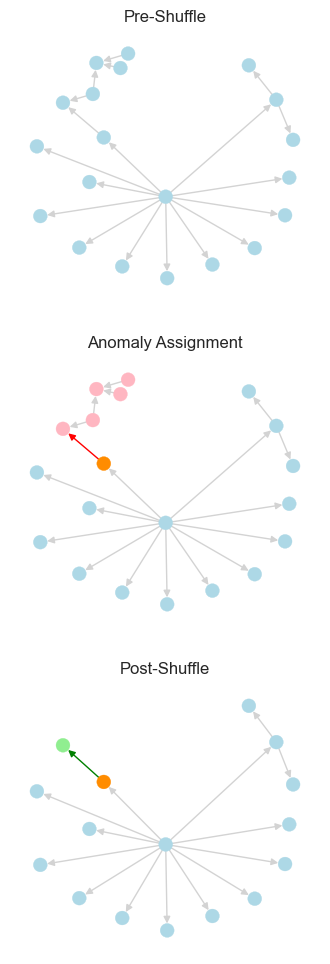

In [711]:
fig, axes = plt.subplots(3, 1, figsize=(4, 12))
axes[0].set_title("Pre-Shuffle")
axes[1].set_title("Anomaly Assignment")
axes[2].set_title("Post-Shuffle")

plot_pre(axes[0])
plot_mid(axes[1])
plot_post(axes[2])

fig.savefig("figures/anomaly-simulation.png", dpi=300, bbox_inches="tight")